In [1]:
import sys
sys.executable # current kernel's path

!/home/ubuntu/anaconda3/envs/pytorch_p36/bin/python -m pip install graphviz
!/home/ubuntu/anaconda3/envs/pytorch_p36/bin/python -m pip install seaborn

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


---
### Transfer Learning
---

- train CNN from scratch (with random initialization) is very hard because of sufficient data size
- instead, use CNN net with pre-trained as an initialization or fixted feature extractors
<br><br>

#### two major transfer learning scenarios
- fine-tuning : initialize with a pre-trained net
- conv net as fixed feature extractor : freeze the weights for all network except final Fully connected layer with random initialization

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import time, os, copy

plt.ion() # interactive mode

In [3]:
print(os.getcwd())
img_path = os.path.join(str(os.getcwd()),'../../data/hymenoptera_data/')
print(img_path)
img_list_train_ants = os.listdir(os.path.join(img_path,'train/ants'))
print(img_list_train_ants[0])

/home/ubuntu/notebooks/pytorch/tuto
/home/ubuntu/notebooks/pytorch/tuto/../../data/hymenoptera_data/
707895295_009cf23188.jpg


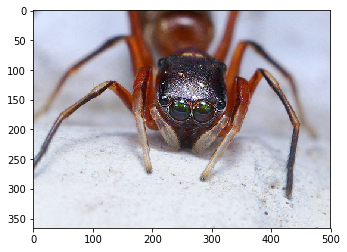

In [4]:
from PIL import Image
import numpy as np
im = Image.open(os.path.join(img_path, 'train/ants',img_list_train_ants[0]))
im2arr = np.array(im) # im2arr.shape: height x width x channel
# arr2im = Image.fromarray(im2arr)

plt.imshow(im2arr)

In [5]:
train_ants = np.array([])
train_bees = np.array([])

for inst in img_list_train_ants:
    tmp_im = np.array(Image.open(os.path.join(img_path, 'train/ants',inst)))
    print(tmp_im.shape)
#     train_ants = tmp_im if len(train_ants) == 0 else np.vstack((train_ants, tmp_im))

(366, 500, 3)
(300, 300)
(333, 500, 3)
(500, 399, 3)
(333, 500, 3)
(374, 500, 3)
(256, 300, 3)
(375, 500, 3)
(445, 600, 3)
(333, 500, 3)
(500, 500, 3)
(375, 500, 3)
(444, 500, 3)
(333, 500, 3)
(432, 500, 3)
(333, 500, 3)
(375, 500, 3)
(238, 320, 3)
(333, 500, 3)
(500, 375, 3)
(272, 199, 3)
(333, 500, 3)
(375, 500, 3)
(333, 500, 3)
(375, 500, 3)
(261, 280, 3)
(333, 500, 3)
(333, 500, 3)
(375, 500, 3)
(137, 200, 3)
(375, 500, 3)
(496, 343, 3)
(333, 500, 3)
(160, 200, 3)
(323, 400, 3)
(374, 500, 3)
(270, 360, 3)
(1984, 1488, 3)
(181, 500, 3)
(357, 500, 3)
(375, 500, 3)
(375, 500, 3)
(375, 500, 3)
(282, 500, 3)
(500, 375, 3)
(375, 500, 3)
(375, 500, 3)
(500, 417, 3)
(375, 500, 3)
(500, 357, 3)
(236, 500, 3)
(400, 500, 3)
(705, 646, 3)
(333, 500, 3)
(356, 500, 3)
(375, 500, 3)
(400, 500, 3)
(500, 441, 3)
(333, 500, 3)
(500, 375, 3)
(333, 500, 3)
(369, 500, 3)
(328, 500, 3)
(348, 500, 3)
(375, 500, 3)
(500, 488, 3)
(423, 500, 3)
(500, 500, 3)
(375, 500, 3)
(236, 343, 3)
(512, 768, 3)
(500, 3

In [6]:
img_path

'/home/ubuntu/notebooks/pytorch/tuto/../../data/hymenoptera_data/'

In [7]:
# Data set : classifying ants and bees
## training : 120 imgs, validation : 75 imgs


# data augmentation and normalization for training
# just normalization for vaildation

data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize(256),        
        transforms.RandomCrop(224), # 224x224 size로 croping
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean / std
    ]),
        
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
    )
    
}

data_dir = img_path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
print(image_datasets)

data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = True, num_workers = 4)
               for x in ['train', 'val']}
data_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(data_sizes)
class_names = image_datasets['train'].classes
print(class_names)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root Location: /home/ubuntu/notebooks/pytorch/tuto/../../data/hymenoptera_data/train
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             RandomCrop(size=(224, 224), padding=0)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None, 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root Location: /home/ubuntu/notebooks/pytorch/tuto/../../data/hymenoptera_data/val
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456,

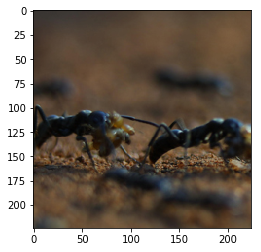

In [8]:
## visualizing few imgs
def imshow(inp, title=None):
    inp = inp.numpy().transpose(1,2,0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
inputs, classes = iter(data_loaders['train']).next()
imshow(inputs[0])

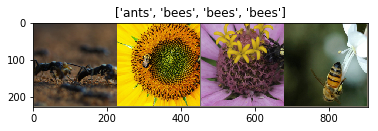

In [9]:
# make grid batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

---
### Training models
---

- 1) ConvNet for pre-trained model

In [55]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2) # add last classifier layer for 2 class
print(model_ft)

# model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

tensor([[ 0.2898, -0.5789]], grad_fn=<ThAddmmBackward>)


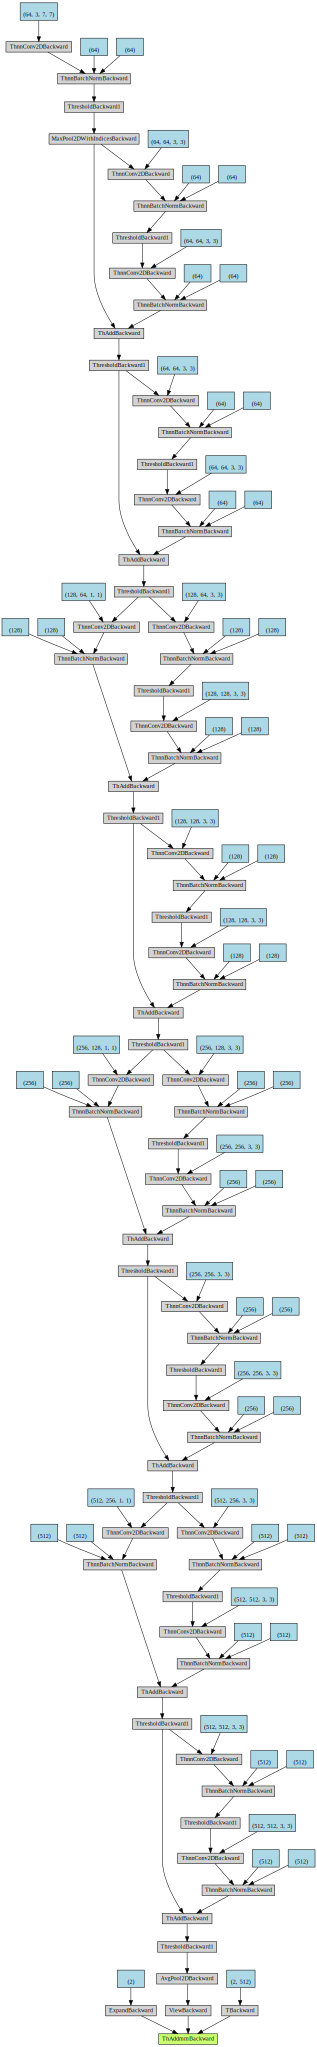

In [56]:
## Model visualization
%matplotlib inline
from dot import make_dot, parse


inputs = torch.randn(1,3,224,224, dtype = torch.float)
model_ft.to('cpu')
y = model_ft(inputs)
print(y)
g = make_dot(y)
g

In [57]:
#  model_ft.state_dict() -> return whole state of the model
    
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start_t = time.time()
    
    # keep the best model state
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss = []
    val_loss = []
    
    i = 0
    
    for epoch in range(num_epochs):
        print("Epoch {} / {}".format(epoch + 1, num_epochs))
        print('-'*10)
        
        # Each epoch has a training and vaildation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaludate(validate) mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # iterattion over data
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero grads
                optimizer.zero_grad()
                
                # forward
                with torch.set_grad_enabled(phase == 'train'): # train일 경우에만 gradients 계산
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only in train phase
                    if phase == 'train':
                        loss.backward() # calculate gradients with embedded autograd fn of pytorch
                        optimizer.step()
                            
                # result summary
                running_loss += loss.item()*inputs.size(0) # mini-batch의 loss가 합해져서 나오기에 x batch 개수만큼
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects.double() / data_sizes[phase]
            
            if phase == 'train':
                train_loss.append((i, epoch_loss, 'loss'))
                train_loss.append((i, epoch_acc.to('cpu').numpy().item(), 'acc'))
            else:
                val_loss.append((i, epoch_loss, 'loss'))
                val_loss.append((i, epoch_acc.to('cpu').numpy().item(), 'acc'))
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy of the updated model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # 여러 epoch 중 가장 결과가 좋았던 epoch 찾기
                best_epoch_num = epoch + 1
                
            if phase == 'val':
                i += 1
                
        print()
        
    time_elapsed = time.time() - start_t
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_epoch_num, (train_loss, val_loss)               

In [58]:
model_ft = model_ft.to(device)
model_ft, best_epoch_num, tot_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 1 / 25
----------
train Loss: 0.8119 Acc: 0.5082
val Loss: 0.6812 Acc: 0.6536

Epoch 2 / 25
----------
train Loss: 0.7615 Acc: 0.5451
val Loss: 0.7803 Acc: 0.6928

Epoch 3 / 25
----------
train Loss: 1.0372 Acc: 0.5164
val Loss: 1.1808 Acc: 0.6601

Epoch 4 / 25
----------
train Loss: 0.8425 Acc: 0.6230
val Loss: 1.1836 Acc: 0.5556

Epoch 5 / 25
----------
train Loss: 0.7445 Acc: 0.6189
val Loss: 0.7437 Acc: 0.6078

Epoch 6 / 25
----------
train Loss: 0.7680 Acc: 0.6434
val Loss: 0.5826 Acc: 0.7255

Epoch 7 / 25
----------
train Loss: 0.6875 Acc: 0.6270
val Loss: 0.7053 Acc: 0.6863

Epoch 8 / 25
----------
train Loss: 0.5733 Acc: 0.7008
val Loss: 0.6266 Acc: 0.7059

Epoch 9 / 25
----------
train Loss: 0.5736 Acc: 0.6926
val Loss: 0.6281 Acc: 0.6993

Epoch 10 / 25
----------
train Loss: 0.5742 Acc: 0.7049
val Loss: 0.6705 Acc: 0.6797

Epoch 11 / 25
----------
train Loss: 0.5289 Acc: 0.7295
val Loss: 0.6536 Acc: 0.6732

Epoch 12 / 25
----------
train Loss: 0.5411 Acc: 0.7336
val Los

In [62]:
best_epoch_num

6

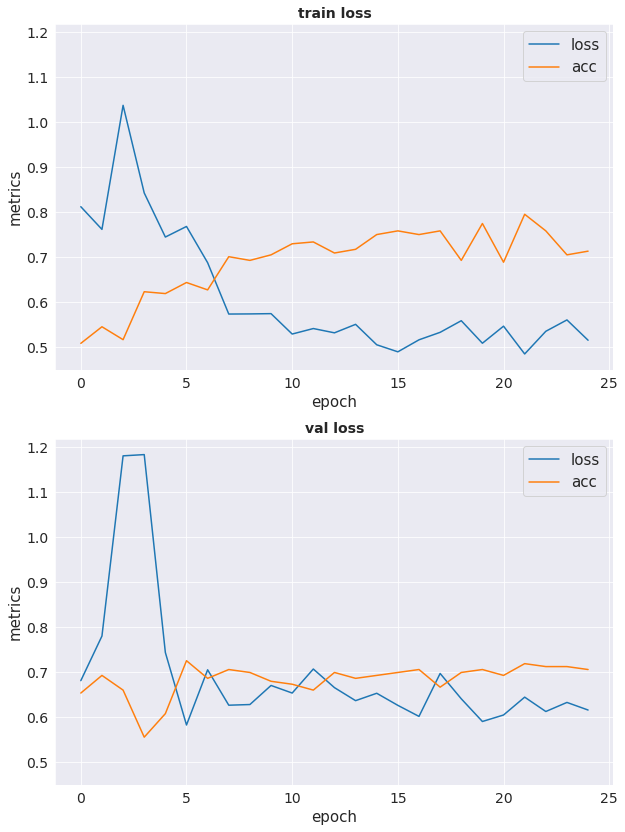

In [84]:
# visualzing for epoch running
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

# loss 관련 data
df_1 = pd.DataFrame(tot_loss[0], columns = ['index','value', 'type']).reset_index()
df_2 = pd.DataFrame(tot_loss[1], columns = ['index','value', 'type']).reset_index()


f, (ax1, ax2) = plt.subplots(2, 1, facecolor = 'white', figsize = (10,14), sharey=True)

legend = ["loss", "acc"]
sns.lineplot(x = 'index', y = 'value', data = df_1, hue = 'type', ax = ax1)
ax1.set_title('train loss', fontsize = 14, fontweight = 'bold')
ax1.set_xlabel('epoch', fontsize=15)
ax1.set_ylabel('metrics', fontsize=15)
ax1.ticklabel_format(style = 'plain', axis = 'y')
ax1.tick_params(labelsize = 14)
ax1.legend(legend, fontsize = 15)


legend = ["loss", "acc"]
sns.lineplot(x = 'index', y = 'value', data = df_2, hue = 'type', ax = ax2)
ax2.set_title('val loss', fontsize = 14, fontweight = 'bold')
ax2.set_xlabel('epoch', fontsize=15)
ax2.set_ylabel('metrics', fontsize=15)
ax2.ticklabel_format(style = 'plain', axis = 'y')
ax2.tick_params(labelsize = 14)
ax2.legend(legend, fontsize = 15)

In [118]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far, facecolor = 'white')
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                ax.set_facecolor('white')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

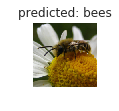

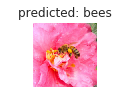

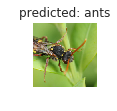

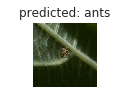

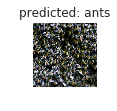

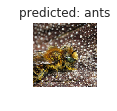

In [119]:
visualize_model(model_ft)

In [120]:
model_pre = models.resnet18(pretrained=True)
num_ftrs = model_pre.fc.in_features
model_pre.fc = nn.Linear(num_ftrs, 2) # add last classifier layer for 2 class
print(model_pre)

# model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ubuntu/.torch/models/resnet18-5c106cde.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [121]:
model_pre = model_pre.to(device)
model_pre, best_epoch_num, tot_loss = train_model(model_pre, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 1 / 25
----------
train Loss: 0.6135 Acc: 0.6926
val Loss: 0.2007 Acc: 0.9281

Epoch 2 / 25
----------
train Loss: 0.3531 Acc: 0.8402
val Loss: 0.1841 Acc: 0.9346

Epoch 3 / 25
----------
train Loss: 0.3285 Acc: 0.8689
val Loss: 0.1773 Acc: 0.9608

Epoch 4 / 25
----------
train Loss: 0.3764 Acc: 0.8607
val Loss: 0.1850 Acc: 0.9412

Epoch 5 / 25
----------
train Loss: 0.4222 Acc: 0.8443
val Loss: 0.2234 Acc: 0.9216

Epoch 6 / 25
----------
train Loss: 0.5335 Acc: 0.8443
val Loss: 0.2485 Acc: 0.9346

Epoch 7 / 25
----------
train Loss: 0.3244 Acc: 0.8852
val Loss: 0.2842 Acc: 0.9020

Epoch 8 / 25
----------
train Loss: 0.1351 Acc: 0.9385
val Loss: 0.2539 Acc: 0.9085

Epoch 9 / 25
----------
train Loss: 0.2946 Acc: 0.8975
val Loss: 0.2819 Acc: 0.8954

Epoch 10 / 25
----------
train Loss: 0.2180 Acc: 0.9139
val Loss: 0.2589 Acc: 0.9085

Epoch 11 / 25
----------
train Loss: 0.1660 Acc: 0.9344
val Loss: 0.2304 Acc: 0.9150

Epoch 12 / 25
----------
train Loss: 0.2381 Acc: 0.9180
val Los

In [122]:
best_epoch_num

3

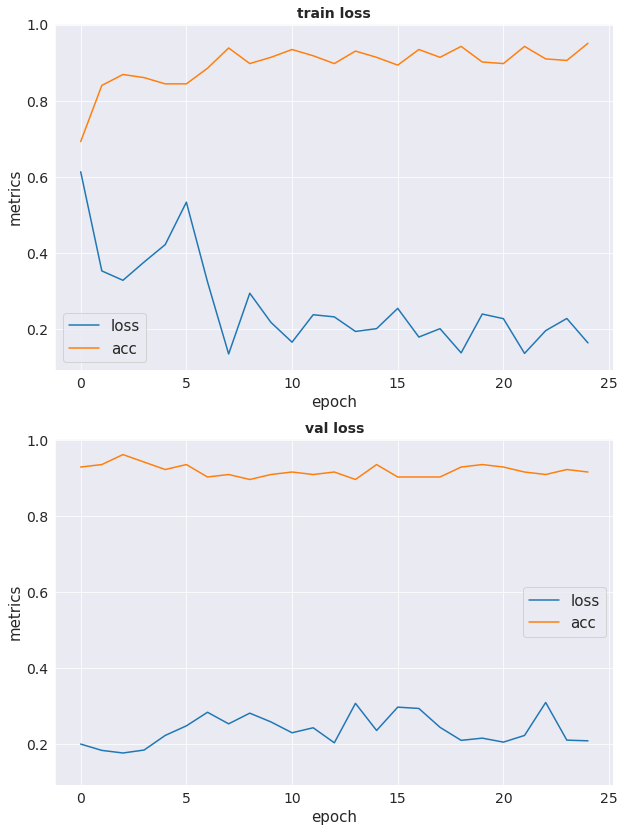

In [123]:
# visualzing for epoch running
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

# loss 관련 data
df_1 = pd.DataFrame(tot_loss[0], columns = ['index','value', 'type']).reset_index()
df_2 = pd.DataFrame(tot_loss[1], columns = ['index','value', 'type']).reset_index()


f, (ax1, ax2) = plt.subplots(2, 1, facecolor = 'white', figsize = (10,14), sharey=True)

legend = ["loss", "acc"]
sns.lineplot(x = 'index', y = 'value', data = df_1, hue = 'type', ax = ax1)
ax1.set_title('train loss', fontsize = 14, fontweight = 'bold')
ax1.set_xlabel('epoch', fontsize=15)
ax1.set_ylabel('metrics', fontsize=15)
ax1.ticklabel_format(style = 'plain', axis = 'y')
ax1.tick_params(labelsize = 14)
ax1.legend(legend, fontsize = 15)


legend = ["loss", "acc"]
sns.lineplot(x = 'index', y = 'value', data = df_2, hue = 'type', ax = ax2)
ax2.set_title('val loss', fontsize = 14, fontweight = 'bold')
ax2.set_xlabel('epoch', fontsize=15)
ax2.set_ylabel('metrics', fontsize=15)
ax2.ticklabel_format(style = 'plain', axis = 'y')
ax2.tick_params(labelsize = 14)
ax2.legend(legend, fontsize = 15)

- 2) ConvNet for feature extracter
  - freeze all the network except final layer -> use pre-trained network for getting feature extraction and only to train the last classifier layer

In [134]:
model_feat = models.resnet18(pretrained=True)
for param in model_feat.parameters():
    param.requires_grad = False
    
num_feat = model_feat.fc.in_features
model_feat.fc = nn.Linear(num_feat, 2) # binary classification
print(list(model_feat.parameters())[-1].requires_grad)

model_feat = model_feat.to(device)
print(model_feat)
# observe that only parameters of final layer are beding optimized as opposed to before
opt_fn = optim.SGD(model_feat.parameters(), lr = 0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(opt_fn, step_size=7, gamma=0.1)

True
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2

In [135]:
model_feat = model_feat.to(device)
model_feat, best_epoch_num, tot_loss = train_model(model_feat, criterion, opt_fn, exp_lr_scheduler, num_epochs=25)

Epoch 1 / 25
----------
train Loss: 0.5791 Acc: 0.7090
val Loss: 0.2310 Acc: 0.9542

Epoch 2 / 25
----------
train Loss: 0.5236 Acc: 0.7500
val Loss: 0.1809 Acc: 0.9542

Epoch 3 / 25
----------
train Loss: 0.4947 Acc: 0.7828
val Loss: 0.3470 Acc: 0.8562

Epoch 4 / 25
----------
train Loss: 0.3512 Acc: 0.8402
val Loss: 0.3629 Acc: 0.8562

Epoch 5 / 25
----------
train Loss: 0.5543 Acc: 0.7664
val Loss: 0.1970 Acc: 0.9477

Epoch 6 / 25
----------
train Loss: 0.4524 Acc: 0.8361
val Loss: 0.1632 Acc: 0.9412

Epoch 7 / 25
----------
train Loss: 0.3910 Acc: 0.8238
val Loss: 0.2774 Acc: 0.9216

Epoch 8 / 25
----------
train Loss: 0.3676 Acc: 0.8648
val Loss: 0.1615 Acc: 0.9477

Epoch 9 / 25
----------
train Loss: 0.2242 Acc: 0.9098
val Loss: 0.1597 Acc: 0.9477

Epoch 10 / 25
----------
train Loss: 0.3648 Acc: 0.8484
val Loss: 0.1536 Acc: 0.9412

Epoch 11 / 25
----------
train Loss: 0.2115 Acc: 0.9098
val Loss: 0.1941 Acc: 0.9346

Epoch 12 / 25
----------
train Loss: 0.2842 Acc: 0.8730
val Los

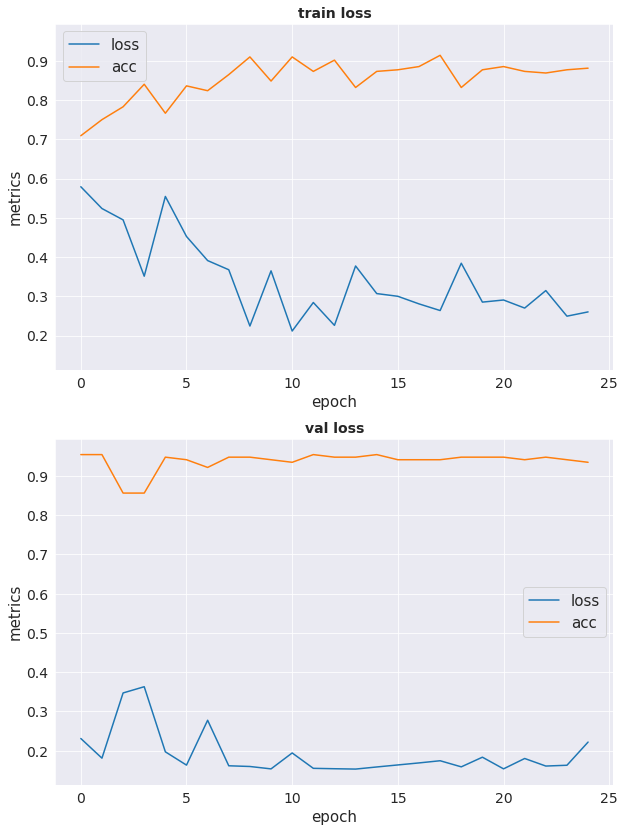

In [136]:
# visualzing for epoch running
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

# loss 관련 data
df_1 = pd.DataFrame(tot_loss[0], columns = ['index','value', 'type']).reset_index()
df_2 = pd.DataFrame(tot_loss[1], columns = ['index','value', 'type']).reset_index()


f, (ax1, ax2) = plt.subplots(2, 1, facecolor = 'white', figsize = (10,14), sharey=True)

legend = ["loss", "acc"]
sns.lineplot(x = 'index', y = 'value', data = df_1, hue = 'type', ax = ax1)
ax1.set_title('train loss', fontsize = 14, fontweight = 'bold')
ax1.set_xlabel('epoch', fontsize=15)
ax1.set_ylabel('metrics', fontsize=15)
ax1.ticklabel_format(style = 'plain', axis = 'y')
ax1.tick_params(labelsize = 14)
ax1.legend(legend, fontsize = 15)


legend = ["loss", "acc"]
sns.lineplot(x = 'index', y = 'value', data = df_2, hue = 'type', ax = ax2)
ax2.set_title('val loss', fontsize = 14, fontweight = 'bold')
ax2.set_xlabel('epoch', fontsize=15)
ax2.set_ylabel('metrics', fontsize=15)
ax2.ticklabel_format(style = 'plain', axis = 'y')
ax2.tick_params(labelsize = 14)
ax2.legend(legend, fontsize = 15)